In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"] = "4"

red_salsa = '#F94144'  # main red colour
orange_red = '#F3722C'
yellow_orange= '#F8961E'
mango_tango = '#F9844A'
maize_crayola = '#F9C74F'  # yellowish
pistachio = '#90BE6D'  # greenish colour
jungle_green = '#43AA8B'
steel_teal = '#4D908E'
queen_blue = '#577590'
celadon_blue = '#277DA1'  # main blue colour

pink = '#FA39FA'


2023-09-14 09:48:56.316157: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 09:48:56.362402: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 09:48:57.133701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATA = 'mnist'
RUNS = 5

train_dict = dict()
val_dict = dict()
var_dict = dict()
time_dict = dict()

In [5]:
SAMPLES = 1

for grad in ['icr', 'rloo', 'gs']:
    val_dict[grad] = []
    train_dict[grad] = []
    var_dict[grad] = []
    time_dict[grad] = []
    for i in range(RUNS):
        logger = pickle.load(open(f"/cw/dtaijupiter/NoCsBack/dtai/lennert/CATSCH/DVAE/results_{DATA}/{grad}_dave_s2_200_1000epochs_lr0.0001_{i}.p", "rb"))
        val_dict[grad].append(list(logger.log_dict["validation_loss"].values()))
        train_dict[grad].append(list(logger.log_dict["training_loss"].values()))
        var_dict[grad].append(list(logger.log_dict["gradient_variance"].values()))
        time_dict[grad].append(list(logger.log_dict["time"].values()))


In [26]:
SAMPLES = 800

for grad in ['rloo', 'gs']:
    val_dict[grad + '800'] = []
    train_dict[grad + '800'] = []
    var_dict[grad + '800'] = []
    time_dict[grad + '800'] = []
    for i in range(RUNS):
        logger = pickle.load(open(f"/cw/dtaijupiter/NoCsBack/dtai/lennert/CATSCH/DVAE/results_{DATA}/{grad}_dave_s800_200_1000epochs_lr0.0001_{i}.p", "rb"))
        val_dict[grad + '800'].append(list(logger.log_dict["validation_loss"].values()))
        train_dict[grad + '800'].append(list(logger.log_dict["training_loss"].values()))
        var_dict[grad + '800'].append(list(logger.log_dict["gradient_variance"].values()))
        time_dict[grad + '800'].append(list(logger.log_dict["time"].values()))


In [7]:
if DATA == 'mnist':
    lim = [60., 140.]
elif DATA == 'fmnist':
    lim = [235., 270.]
else:
    lim = [95., 160.]

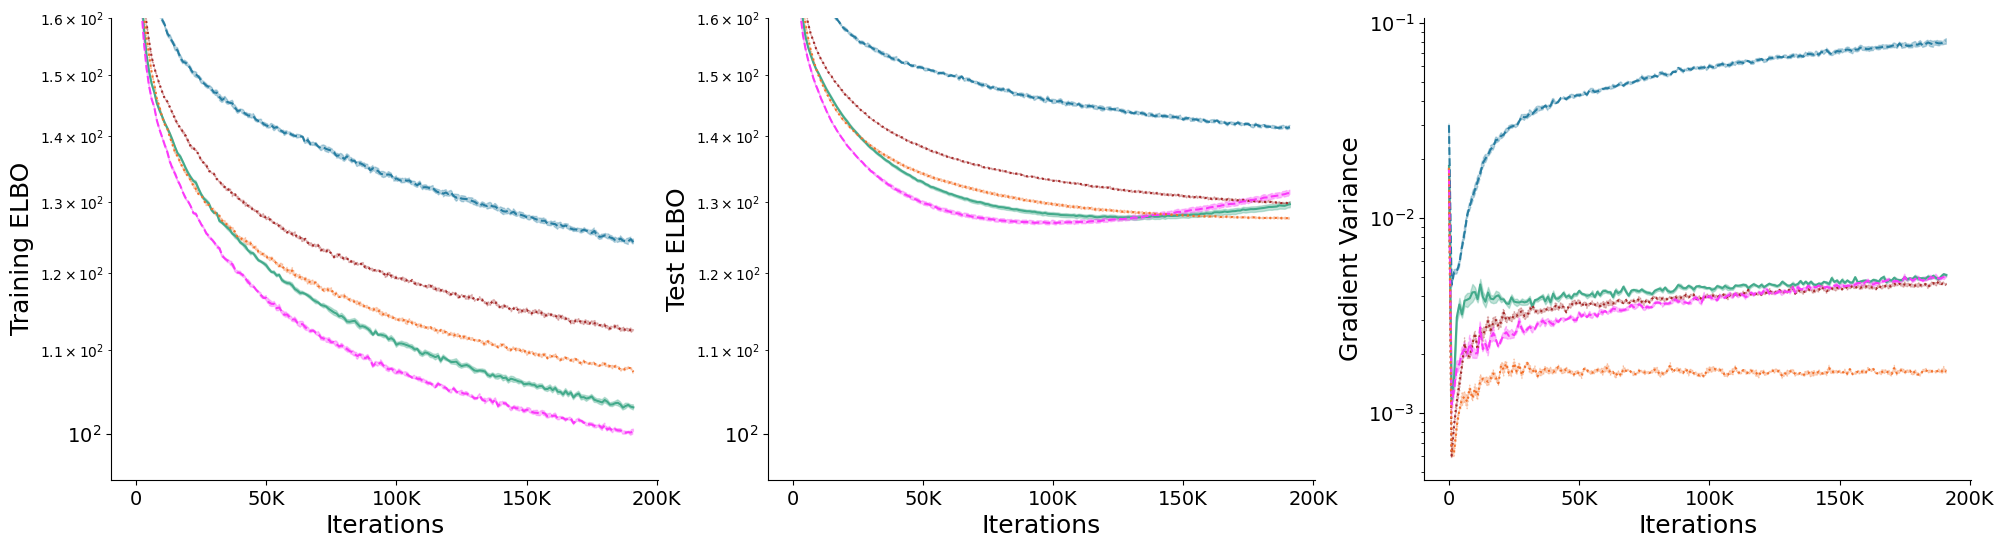

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
data = [train_dict, val_dict, var_dict]
K = 10
L = len(train_dict['icr'][0])

its = [i * 100 for i in range(L)]
colours = [jungle_green, celadon_blue, 'brown', pink, orange_red]
labels = ['IndeCateR', 'RLOO-S', 'GS-S', 'RLOO-F', 'GS-F']
linestyle = ['solid', 'dashed', 'dotted', 'dashed', 'dotted']
for i, ds in enumerate(data):
    avg_dict = dict()
    std_dict = dict()
    for j, grad in enumerate(['icr', 'rloo', 'gs', 'rloo800', 'gs800']):
        avg_dict[grad] = []
        std_dict[grad] = []
        avg_dict[grad].append(tf.squeeze(tf.reduce_mean(ds[grad], axis=0))[:L])
        std_dict[grad].append(tf.squeeze(tf.math.reduce_std(ds[grad], axis=0))[:L] / np.sqrt(RUNS))

        axs[i].set_xlabel('Iterations', fontsize=18)
        if i == 0:
            axs[i].set_ylabel('Training ELBO', fontsize=18)
            axs[i].set_ylim(lim)
        elif i == 1:
            axs[i].set_ylabel('Test ELBO', fontsize=18)
            axs[i].set_ylim(lim)
        else:
            axs[i].set_ylabel('Gradient Variance', fontsize=18)
        axs[i].plot(its[::K], avg_dict[grad][0][::K], color=colours[j], label=labels[j], linestyle=linestyle[j])
        axs[i].fill_between(its[::K], avg_dict[grad][0][::K] - std_dict[grad][0][::K], avg_dict[grad][0][::K] + std_dict[grad][0][::K], alpha=0.33, color=colours[j], linestyle=linestyle[j])
        axs[i].spines[['right', 'top']].set_visible(False)
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        if DATA == 'omniglot':
            axs[i].set_xticks([i * 50000 for i in range(5)], ['0', '50K', '100K', '150K', '200K'])
        else:
            axs[i].set_xticks([i * 100000 for i in range(7)], ['0', '100K', '200K', '300K', '400K', '500K', '600K'])
        axs[i].set_yscale('log')

if DATA == 'mnist':
    handles, labels = axs[-1].get_legend_handles_labels()
    leg = fig.legend(handles, labels, frameon=False, fontsize=24, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))
    for line in leg.get_lines():
        line.set_linewidth(4)
fig.savefig(f"/cw/dtaijupiter/NoCsBack/dtai/lennert/CATSCH/DVAE/plots/{DATA}_vae_its.pdf", dpi=300, bbox_inches='tight', transparent=True)

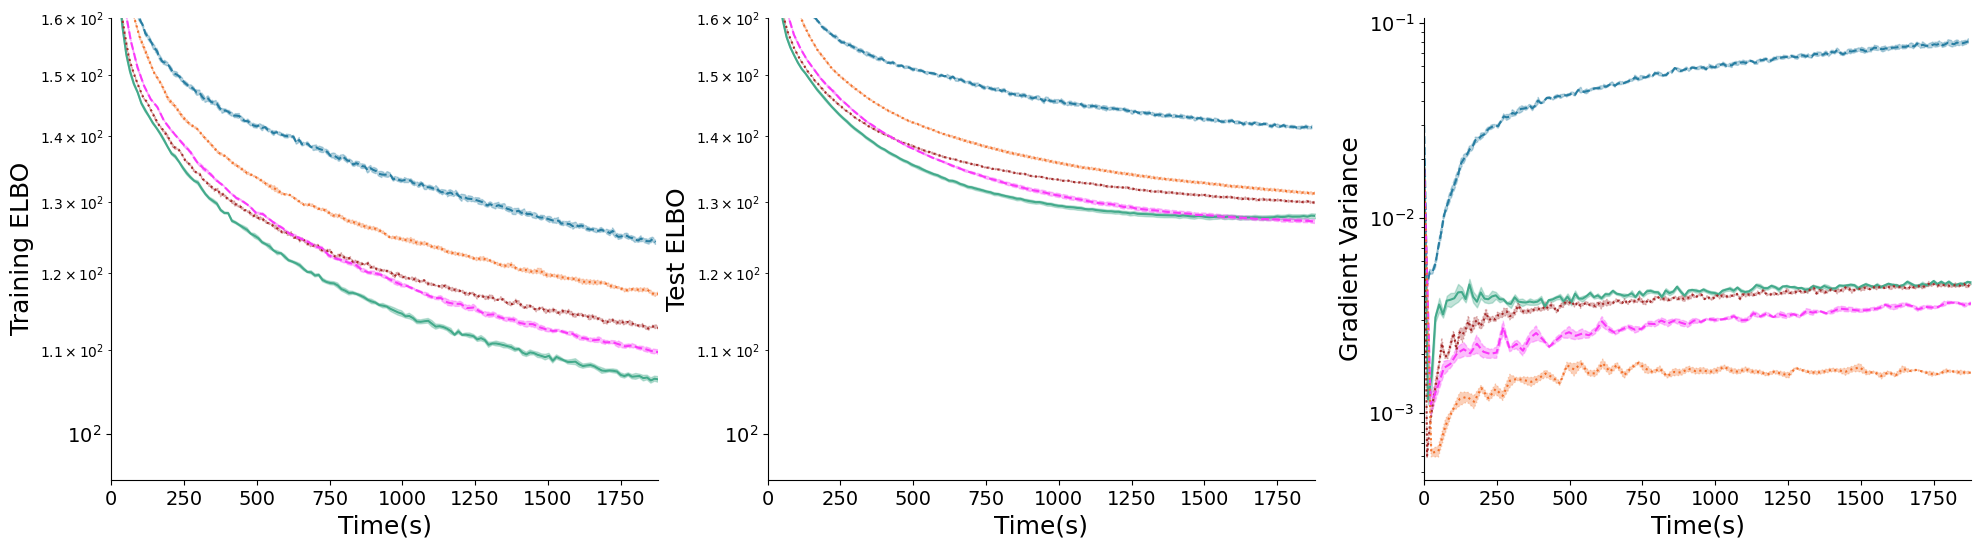

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
data = [train_dict, val_dict, var_dict]

t = np.array([i for i in range(L)])
t_min = np.min([np.sum(np.mean(time_dict[grad], axis=0)) for grad in ['icr', 'rloo', 'gs', 'rloo800', 'gs800']])

colours = [jungle_green, celadon_blue, 'brown', pink, orange_red]
labels = ['IndeCateR', 'RLOO-S', 'GS-S', 'RLOO-F', 'GS-F']
linestyle = ['solid', 'dashed', 'dotted', 'dashed', 'dotted']
for i, ds in enumerate(data):
    avg_dict = dict()
    std_dict = dict()
    for j, grad in enumerate(['icr', 'rloo', 'gs', 'rloo800', 'gs800']):
        avg_dict[grad] = []
        std_dict[grad] = []
        avg_dict[grad].append(tf.squeeze(tf.reduce_mean(ds[grad], axis=0))[:L])
        std_dict[grad].append(tf.squeeze(tf.math.reduce_std(ds[grad], axis=0))[:L] / np.sqrt(RUNS))

        grad_t = t * np.mean(time_dict[grad])
        axs[i].set_xlabel('Time(s)', fontsize=18)
        if i == 0:
            axs[i].set_ylabel('Training ELBO', fontsize=18)
            axs[i].set_ylim(lim)
        elif i == 1:
            axs[i].set_ylabel('Test ELBO', fontsize=18)
            axs[i].set_ylim(lim)
        else:
            axs[i].set_ylabel('Gradient Variance', fontsize=18)
        axs[i].plot(grad_t[::K], avg_dict[grad][0][::K], color=colours[j], label=labels[j], linestyle=linestyle[j])
        axs[i].fill_between(grad_t[::K], avg_dict[grad][0][::K] - std_dict[grad][0][::K], avg_dict[grad][0][::K] + std_dict[grad][0][::K], alpha=0.33, color=colours[j], linestyle=linestyle[j])
        axs[i].spines[['right', 'top']].set_visible(False)
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_yscale('log')
        axs[i].set_xlim([0., t_min])

if DATA == 'mnist':
    handles, labels = axs[-1].get_legend_handles_labels()
    leg = fig.legend(handles, labels, frameon=False, fontsize=24, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))
    for line in leg.get_lines():
        line.set_linewidth(4)
fig.savefig(f"/cw/dtaijupiter/NoCsBack/dtai/lennert/CATSCH/DVAE/plots/{DATA}_vae_time.pdf", dpi=300, bbox_inches='tight', transparent=True)